In [2]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from pprint import pprint

In [3]:
# for each log in logs load json dump and write to dict with filename as key
folder_path = "logs"

# Initialize an empty list to store the parsed data
parsed_data = []

# Loop through each file in the directory
for filename in os.listdir(folder_path):
    # Check if the file is a JSON file
    if filename.endswith(".json"):
        # Construct the full path of the file
        file_path = os.path.join(folder_path, filename)

        # Open and parse the JSON file
        with open(file_path, "r") as file:
            data = json.load(file)

        # Store the parsed data in a dictionary using the filename as the key
        parsed_data.append(data)

# Now, `parsed_data` is a dictionary where each key is the filename and each value is the corresponding JSON data
pprint(parsed_data, indent=1)

[{'average_bit_width': 2.0844444444444443,
  'error_threshold': 12,
  'layerwise_quantization_info': {'lm_head': {'bit_width': 2,
                                              'error': 13.61251449584961},
                                  'model.layers.0.mlp.down_proj': {'bit_width': 2,
                                                                   'error': 16.453411102294922},
                                  'model.layers.0.mlp.gate_proj': {'bit_width': 2,
                                                                   'error': 15.230063438415527},
                                  'model.layers.0.mlp.up_proj': {'bit_width': 2,
                                                                 'error': 13.69078540802002},
                                  'model.layers.0.self_attn.k_proj': {'bit_width': 2,
                                                                      'error': 21.262279510498047},
                                  'model.layers.0.self_attn.o_proj': {'bit

In [4]:
# Creating differerent data structure with:
# {
#     "model_name" : {
#         [
#         "error_threshold_1": {
#             "(min_quantile, max_quantile)": {
#                 "quantized_model_accuracy": value,
#                 "average_bit_width": value,
#                 "layerwise_quantization_info": dict
#             }
#         }
#         "error_threshold_2": {
#             ...
#         }
#         ]
#     }
#     "original_model_accuracy": value
# }

# Initialize an empty dictionary to store the parsed data
data = {}
for filename in os.listdir(folder_path):
    # Check if the file is a JSON file
    if filename.endswith(".json"):
        # Construct the full path of the file
        file_path = os.path.join(folder_path, filename)

        # Open and parse the JSON file
        with open(file_path, "r") as file:
            model_data = json.load(file)

        # Store the parsed data in a dictionary using the filename as the key
        model_name = model_data["model_name"]
        original_model_accuracy = model_data["original_model_accuracy"]
        quantization_data = {
            "error_threshold": model_data["error_threshold"],
            "quantized_model_accuracy": model_data["quantized_model_accuracy"],
            "average_bit_width": model_data["average_bit_width"],
            "min_quantile": model_data["min_quantile"],
            "max_quantile": model_data["max_quantile"],
            "layerwise_quantization_info": model_data["layerwise_quantization_info"],
        }

        # If the model name does not exist in the dictionary, add it
        if model_name not in data:
            data[model_name] = {
                "original_model_accuracy": original_model_accuracy,
                "quantization_data": [],
            }

        # Add the quantization data to the dictionary
        data[model_name]["quantization_data"].append(quantization_data)

pprint(data)

{'HuggingFaceTB/SmolLM-135M-Instruct': {'original_model_accuracy': 0.39463618573207615,
                                        'quantization_data': [{'average_bit_width': 2.066350710900474,
                                                               'error_threshold': 10,
                                                               'layerwise_quantization_info': {'lm_head': {'bit_width': 2,
                                                                                                           'error': 14.328621864318848},
                                                                                               'model.layers.0.mlp.down_proj': {'bit_width': 2,
                                                                                                                                'error': 16.830753326416016},
                                                                                               'model.layers.0.mlp.gate_proj': {'bit_width': 2,
                 

In [5]:
for model, model_data in data.items():
    print(f"Model: {model}")
    print(f"Original Model Accuracy: {model_data['original_model_accuracy']}")
    for quantization_data in model_data["quantization_data"]:
        print(f"Error Threshold: {quantization_data['error_threshold']}")
        print(
            f"Quantized Model Accuracy: {quantization_data['quantized_model_accuracy']}"
        )
        print(f"Average Bit Width: {quantization_data['average_bit_width']}")
        print(f"Min Quantile: {quantization_data['min_quantile']}")
        print(f"Max Quantile: {quantization_data['max_quantile']}")
        print()

Model: meta-llama/Llama-3.1-8B-Instruct
Original Model Accuracy: 0.5299508376688463
Error Threshold: 12
Quantized Model Accuracy: 0.45802109684501935
Average Bit Width: 2.0844444444444443
Min Quantile: 0.1
Max Quantile: 0.9

Error Threshold: 15
Quantized Model Accuracy: 0.48494105293303424
Average Bit Width: 2.6755555555555555
Min Quantile: 0.05
Max Quantile: 0.95

Error Threshold: 20
Quantized Model Accuracy: 0.5152975991599447
Average Bit Width: 3.088888888888889
Min Quantile: 0.1
Max Quantile: 0.9

Error Threshold: 20
Quantized Model Accuracy: 0.518972841391819
Average Bit Width: 3.52
Min Quantile: 0.05
Max Quantile: 0.95

Error Threshold: 10
Quantized Model Accuracy: 0.26289914562550715
Average Bit Width: 2.582222222222222
Min Quantile: 0.01
Max Quantile: 0.99

Error Threshold: 15
Quantized Model Accuracy: 0.4868025392582693
Average Bit Width: 3.328888888888889
Min Quantile: 0.01
Max Quantile: 0.99

Error Threshold: 10
Quantized Model Accuracy: 0.39315545797336643
Average Bit Width

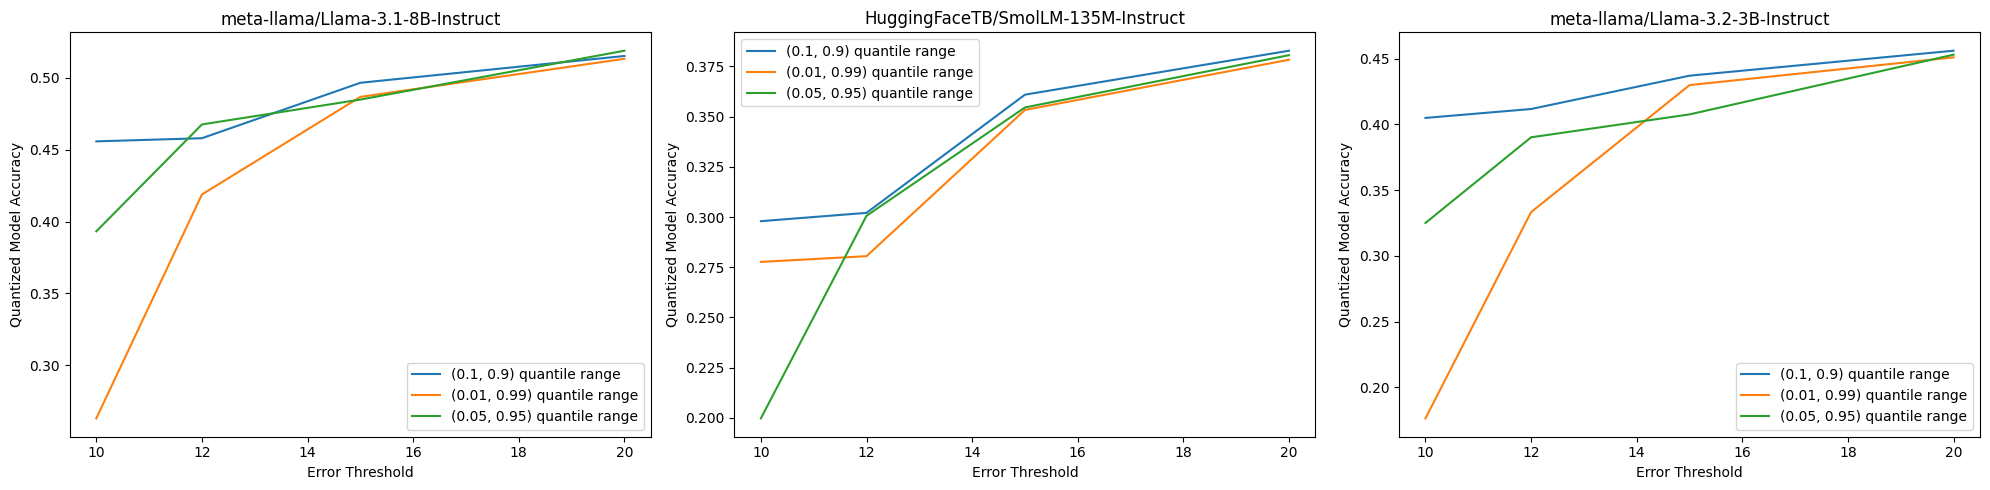

In [6]:
# Create Subplots per model
# For each quantile range [(0.0, 1.0), (0.01, 0.99), (0.05, 0.95)]
# x-axis is the sqnr dB with labels and error_threshold as value
# y-axis is the model quantized model accuracy

fig, ax = plt.subplots(1, len(data), figsize=(20, 5))

for i, (model_name, model_data) in enumerate(data.items()):
    original_model_accuracy = model_data["original_model_accuracy"]
    quantization_data = model_data["quantization_data"]
    lines = []

    for quantile_range in [(0.1, 0.9), (0.01, 0.99), (0.05, 0.95)]:
        x = []
        y = []

        for quantization_info in quantization_data:
            if (
                quantization_info["min_quantile"] != quantile_range[0]
                or quantization_info["max_quantile"] != quantile_range[1]
            ):
                continue
            error_threshold = quantization_info["error_threshold"]
            quantized_model_accuracy = quantization_info["quantized_model_accuracy"]
            layerwise_quantization_info = quantization_info[
                "layerwise_quantization_info"
            ]

            x.append(error_threshold)
            y.append(quantized_model_accuracy)
        
        # Sort the x and y values based on the x values
        x, y = zip(*sorted(zip(x, y)))

        (line,) = ax[i].plot(x, y, label=f"{quantile_range} quantile range")
        lines.append(line)

    ax[i].set_title(model_name)
    ax[i].set_xlabel("Error Threshold")
    ax[i].set_ylabel("Quantized Model Accuracy")
    ax[i].legend(handles=lines)

plt.tight_layout()
plt.show()

In [4]:
# Visualize logs for SmolLM-135M
folder_path = "logs"
parsed_data = {}
for filename in os.listdir(folder_path):
    if filename.endswith(".json") and "SmolLM-135M" in filename:
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)
        parsed_data[filename] = data

print(len(parsed_data))
pprint(parsed_data, indent=1)

12
{'HuggingFaceTB_SmolLM-135M-Instruct_quantization_10dB_min-0.01_max-0.99_2024-11-23_20-04-26.json': {'average_bit_width': 2.914691943127962,
                                                                                                     'error_threshold': 10,
                                                                                                     'layerwise_quantization_info': {'lm_head': {'bit_width': 2,
                                                                                                                                                 'error': 11.475921630859375},
                                                                                                                                     'model.layers.0.mlp.down_proj': {'bit_width': 2,
                                                                                                                                                                      'error': 12.240549087524414},
                  

Text(0.5, 1.0, 'Max Threshold vs. Average Bitwidth for SmolLM-135M')

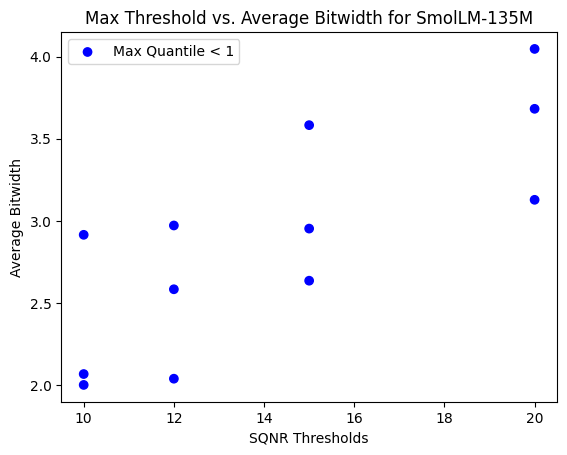

In [5]:
error_thresholds = []
average_bitwidths = []
colors = []

for filename, log_data in parsed_data.items():
    # if log_data["max_quantile"] >= 1:
    # continue

    if log_data["max_quantile"] < 1:
        colors.append("blue")
    else:
        colors.append("red")

    error_threshold = log_data["error_threshold"]
    average_bitwidth = log_data["average_bit_width"]
    error_thresholds.append(error_threshold)
    average_bitwidths.append(average_bitwidth)

    # print(f"{filename}: {error_threshold} {average_bitwidth}")

mpl.scatter(error_thresholds, average_bitwidths, c=colors)
mpl.xlabel("SQNR Thresholds")
mpl.ylabel("Average Bitwidth")
# legend blue means max quantile < 1, red means max quantile >= 1
# add colors
mpl.legend(["Max Quantile < 1", "Max Quantile >= 1"])
mpl.title(f"Max Threshold vs. Average Bitwidth for SmolLM-135M")

In [ ]:
self_attn_bitwidths = []
lm_head_bitwidths = []
mlp_bitwidths = []
for i, (filename, log_data) in enumerate(parsed_data.items()):
    layers = log_data["layerwise_quantization_info"]
    for layer, layer_data in layers.items():
        if "self_attn" in layer:
            self_attn_bitwidths.append(layer_data["bit_width"])
        elif "lm_head" in layer:
            lm_head_bitwidths.append(layer_data["bit_width"])
        elif "mlp" in layer:
            mlp_bitwidths.append(layer_data["bit_width"])
    if i == 0:
        break

# bar diagram for average bitwidths for each layer type
mpl.bar(
    ["self_attn", "lm_head", "mlp"],
    [
        sum(self_attn_bitwidths) / len(self_attn_bitwidths),
        sum(lm_head_bitwidths) / len(lm_head_bitwidths),
        sum(mlp_bitwidths) / len(mlp_bitwidths),
    ],
)
mpl.xlabel("Layer Type")
mpl.ylabel("Average Bitwidth")
mpl.title(f"Average Bitwidth for each Layer Type for SmolLM-135M")

In [ ]:
# Visualize logs for SmolLM-135M
folder_path = "logs"
parsed_data = {}
for filename in os.listdir(folder_path):
    if filename.endswith(".json") and "Llama-3.2-3B" in filename:
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)
        parsed_data[filename] = data

print(len(parsed_data))
pprint(parsed_data, indent=1)

self_attn_bitwidths = []
lm_head_bitwidths = []
mlp_bitwidths = []
for i, (filename, log_data) in enumerate(parsed_data.items()):
    if "3B" not in filename:
        continue
    layers = log_data["layerwise_quantization_info"]
    for layer, layer_data in layers.items():
        if "self_attn" in layer:
            self_attn_bitwidths.append(layer_data["bit_width"])
        elif "lm_head" in layer:
            lm_head_bitwidths.append(layer_data["bit_width"])
        elif "mlp" in layer:
            mlp_bitwidths.append(layer_data["bit_width"])
    if i == 0:
        break

# bar diagram for average bitwidths for each layer type
mpl.bar(
    ["self_attn", "lm_head", "mlp"],
    [
        sum(self_attn_bitwidths) / len(self_attn_bitwidths),
        sum(lm_head_bitwidths) / len(lm_head_bitwidths),
        sum(mlp_bitwidths) / len(mlp_bitwidths),
    ],
)
mpl.xlabel("Layer Type")
mpl.ylabel("Average Bitwidth")
mpl.title(f"Average Bitwidth for each Layer Type for Llama3.2-3B")